<a href="https://colab.research.google.com/github/YirenShen-07/590Assignment/blob/main/%E2%80%9CYiren590third_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### link to the location in your github repository is above
# AIPI 590 - XAI | Assignment #2 - Third Adversarial Patch

### I created three adversarial patches, and this file contains the third adversarial patch. I used part of the professor's method and added some of my own creative components. The other two files can be found in the files on the left.
### Yiren Shen


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AIPI-590-XAI/Duke-AI-XAI/blob/dev/templates/template.ipynb)

In [ ]:
!pip install adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models import ResNet34_Weights
import numpy as np
from tqdm import tqdm
import os
import json
from urllib.request import urlopen

# Using the CPU and updating the model loading method
device = torch.device("cpu")
pretrained_model = torchvision.models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).to(device)

# Download ImageNet Category List
imagenet_classes_url = "https://raw.githubusercontent.com/AIPI-590-XAI/Duke-AI-XAI/main/adversarial-ai-example-notebooks/imagenet_classes.txt"
with urlopen(imagenet_classes_url) as response:
    imagenet_classes = response.read().decode().splitlines()

# Creating smaller simulated ImageNet datasets
class SimulatedImageNet(torch.utils.data.Dataset):
    def __init__(self, num_classes=1000, num_samples=1000, image_size=224):
        self.num_classes = num_classes
        self.num_samples = num_samples
        self.image_size = image_size
        self.data = torch.randn(num_samples, 3, image_size, image_size)
        self.targets = torch.randint(0, num_classes, (num_samples,))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

# Creating a Simulated ImageNet Dataset Example
dataset = SimulatedImageNet(num_samples=1000)

In [ ]:
def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0, img.shape[2] - patch.shape[1] - 1)
        w_offset = np.random.randint(0, img.shape[3] - patch.shape[2] - 1)
        img[i, :, h_offset:h_offset+patch.shape[1], w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

def patch_forward(patch):
    patch = (torch.tanh(patch) + 1) / 2
    return patch

def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    return acc, top5

def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    dataset_size = len(dataset)
    train_size = int(0.8 * dataset_size)
    val_size = dataset_size - train_size
    train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, drop_last=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=False, drop_last=False, num_workers=2)

    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    acc, top5 = eval_patch(model, patch, val_loader, target_class)

    return patch.data, {"acc": acc.item(), "top5": top5.item()}

# Adversarial Patch Desk

In [ ]:
# find desk
desk_class_index = imagenet_classes.index("desk")
patch_sizes = [64]
result_dict = {}

for patch_size in patch_sizes:
    patch, results = patch_attack(pretrained_model, target_class=desk_class_index, patch_size=patch_size, num_epochs=5)
    result_dict[patch_size] = {
        "results": results,
        "patch": patch
    }
    print(f"Results for desk patch of size {patch_size}:", results)

# save results
def save_results(result_dict, filename="desk_patch_results_resnet34_cpu_small_simulated_imagenet.json"):
    save_dict = {str(psize): {"acc": results["results"]["acc"], "top5": results["results"]["top5"]}
                 for psize, results in result_dict.items()}
    with open(filename, "w") as f:
        json.dump(save_dict, f, indent=4)

save_results(result_dict)



Results for desk patch of size 64: {'acc': 0.0, 'top5': 0.0}


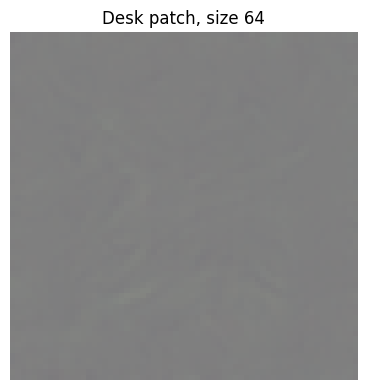

In [ ]:
def show_patches(result_dict):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    for psize, results in result_dict.items():
        patch = results["patch"]
        patch = (torch.tanh(patch) + 1) / 2
        patch = patch.cpu().permute(1, 2, 0).numpy()
        patch = np.clip(patch, a_min=0.0, a_max=1.0)
        ax.imshow(patch)
        ax.set_title(f"Desk patch, size {psize}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_patches(result_dict)

# Reference

Tutorial 10 Adversarial attacks: https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb#scrollTo=JwbxjCgY9FWJ

Chatgpt modification of Python code for generating adversarial patches.